<a href="https://colab.research.google.com/github/saritdi/PlantClassification/blob/main/Sarit_My_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Stage 1: Install dependencies and setting up GPU environment
!pip install tensorflow-gpu==2.3.0

     |████████████████████████████████| 320.4MB 55kB/s 
     |████████████████████████████████| 20.1MB 1.5MB/s 
     |████████████████████████████████| 460kB 37.2MB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.3.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0


In [ ]:
# Importing a library that is not in Colaboratory
!apt-get -qq install -y libfluidsynth1
!pip install matplotlib-venn

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [ ]:
!pip install tqdm

In [ ]:
# Dataset preprocessing
# Import project dependencies
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


%matplotlib inline
tf.__version__

'2.3.0'

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

In [ ]:
  # Authenticate and create the PyDrive client.
drive.mount('/content/gdrive')
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
driver = GoogleDrive(gauth)


Mounted at /content/gdrive


In [ ]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

228818944/228813984 [==============================] - 2s 0us/step
3670


In [ ]:
!ls /content/gdrive/MyDrive

 BlockChaiin		 'My forth year-Ipad'	  VGG19.h5
'Colab Notebooks'	  MyHousePlants.zip	  Xception.h5
'Copy of moed b.pdf'	 'MyProject (1).zip'	  אורחים
'CV Sarit Divekar.docx'   MyProject.zip		 'בוחן אלגו 2'
 EfficientNetB4.h5	  PPL-2021-ב.pdf	  יזמות
 EfficientNetB5.h5	 'Resume template.gdoc'  'מדעי המחשב בן גוריון'
 EfficientNetB6.h5	 'Sample upload.txt'	 'משרד החינוך'
 EfficientNetB7.h5	  Test.zip		 'קורסי בחירה'
 Hadar-Saritt.zip	 'To-do list.gsheet'


In [ ]:
# Setting up data import for google Drive
# Training data
fid = driver.ListFile({'q':"title='MyHousePlants.zip'"}).GetList()[0]['id']
f = driver.CreateFile({'id': fid})
f.GetContentFile('MyHousePlants.zip')

# Testing data
fid1 = driver.ListFile({'q':"title='Test.zip'"}).GetList()[0]['id']
f1 = driver.CreateFile({'id': fid1})
f1.GetContentFile('Test.zip')




In [ ]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [ ]:
f1.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [ ]:
!unzip MyHousePlants.zip

Archive:  MyHousePlants.zip
   creating: MyHousePlants/
   creating: MyHousePlants/Daisy/
  inflating: MyHousePlants/Daisy/10437929963_bc13eebe0c.jpg  
  inflating: MyHousePlants/Daisy/10466290366_cc72e33532.jpg  
  inflating: MyHousePlants/Daisy/10466558316_a7198b87e2.jpg  
  inflating: MyHousePlants/Daisy/10555749515_13a12a026e.jpg  
  inflating: MyHousePlants/Daisy/10555815624_dc211569b0.jpg  
  inflating: MyHousePlants/Daisy/10555826524_423eb8bf71_n.jpg  
  inflating: MyHousePlants/Daisy/10559679065_50d2b16f6d.jpg  
  inflating: MyHousePlants/Daisy/10712722853_5632165b04.jpg  
  inflating: MyHousePlants/Daisy/10770585085_4742b9dac3_n.jpg  
  inflating: MyHousePlants/Daisy/10841136265_af473efc60.jpg  
  inflating: MyHousePlants/Daisy/10993710036_2033222c91.jpg  
  inflating: MyHousePlants/Daisy/10993818044_4c19b86c82.jpg  
  inflating: MyHousePlants/Daisy/10994032453_ac7f8d9e2e.jpg  
  inflating: MyHousePlants/Daisy/11023214096_b5b39fab08.jpg  
  inflating: MyHousePlants/Daisy/11023

In [ ]:
!unzip Test.zip

Archive:  Test.zip
   creating: Test/
   creating: Test/Daisy/
  inflating: Test/Daisy/15207766_fc2f1d692c_n.jpg  
  inflating: Test/Daisy/21652746_cc379e0eea_m.jpg  
  inflating: Test/Daisy/2454280137_e1637536ae_n.jpg  
  inflating: Test/Daisy/2514748602_343d4727c0_n.jpg  
  inflating: Test/Daisy/2520369272_1dcdb5a892_m.jpg  
  inflating: Test/Daisy/2521408074_e6f86daf21_n.jpg  
  inflating: Test/Daisy/25360380_1a881a5648.jpg  
  inflating: Test/Daisy/2536529152_33ef3ee078_n.jpg  
  inflating: Test/Daisy/2538504987_fe524b92a8_n.jpg  
  inflating: Test/Daisy/43474673_7bb4465a86.jpg  
  inflating: Test/Daisy/510844526_858b8fe4db.jpg  
  inflating: Test/Daisy/512177035_70afc925c8.jpg  
  inflating: Test/Daisy/525780443_bba812c26a_m.jpg  
  inflating: Test/Daisy/530738000_4df7e4786b.jpg  
  inflating: Test/Daisy/534547364_3f6b7279d2_n.jpg  
  inflating: Test/Daisy/54377391_15648e8d18.jpg  
  inflating: Test/Daisy/5547758_eea9edfd54_n.jpg  
  inflating: Test/Daisy/5673551_01d1ea993e_n.jpg 

In [ ]:
PATH = '/content'
os.listdir(PATH)

['.config',
 'MyHousePlants.zip',
 'adc.json',
 'Test',
 'MyHousePlants',
 'gdrive',
 'Test.zip',
 'sample_data']

In [ ]:
train_data_dir = os.path.join(PATH,'MyHousePlants')
test_data_dir = os.path.join(PATH,'Test')
print(os.listdir(train_data_dir))


['Daisy', 'Fittonia Verschaffeltii', 'Paddle Plant', 'Dandelion', 'Sansevieria Ballyi', 'Zebra Plant', 'Moon Cactus', 'Sunflower', 'Parlor Palm', 'Sempervivum', 'Lucky Bamboo', 'Tulip', 'String Of Banana', 'Rose', 'Jade Plant']


In [ ]:
print(os.listdir(test_data_dir))

['Daisy', 'Fittonia Verschaffeltii', 'Paddle Plant', 'Dandelion', 'Sansevieria Ballyi', 'Zebra Plant', 'Moon Cactus', 'Sunflower', 'Parlor Palm', 'Sempervivum', 'Lucky Bamboo', 'Tulip', 'String Of Banana', 'Rose', 'Jade Plant']


In [ ]:
# Preparing the data
IMG_HEIGHT = 128
IMG_WIDTH = 128
batch_size = 32

# # Image normalization
# Image Data Augmentation
# # 255.0 is the highest pixel value
image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip = True,
    rotation_range = 90,
    brightness_range = [0.2,1.0],
    zoom_range = [0.5,1.0]
    )

train_data_generator = image_generator.flow_from_directory(
    directory=train_data_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset="training",
    class_mode='sparse')

valid_data_generator = image_generator.flow_from_directory(
    directory=train_data_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset="validation",
    class_mode='sparse')

test_data_generator = image_generator.flow_from_directory(
    directory=test_data_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'sparse')

class_names = list(train_data_generator.class_indices.keys())

Found 1373 images belonging to 15 classes.
Found 335 images belonging to 15 classes.
Found 188 images belonging to 15 classes.


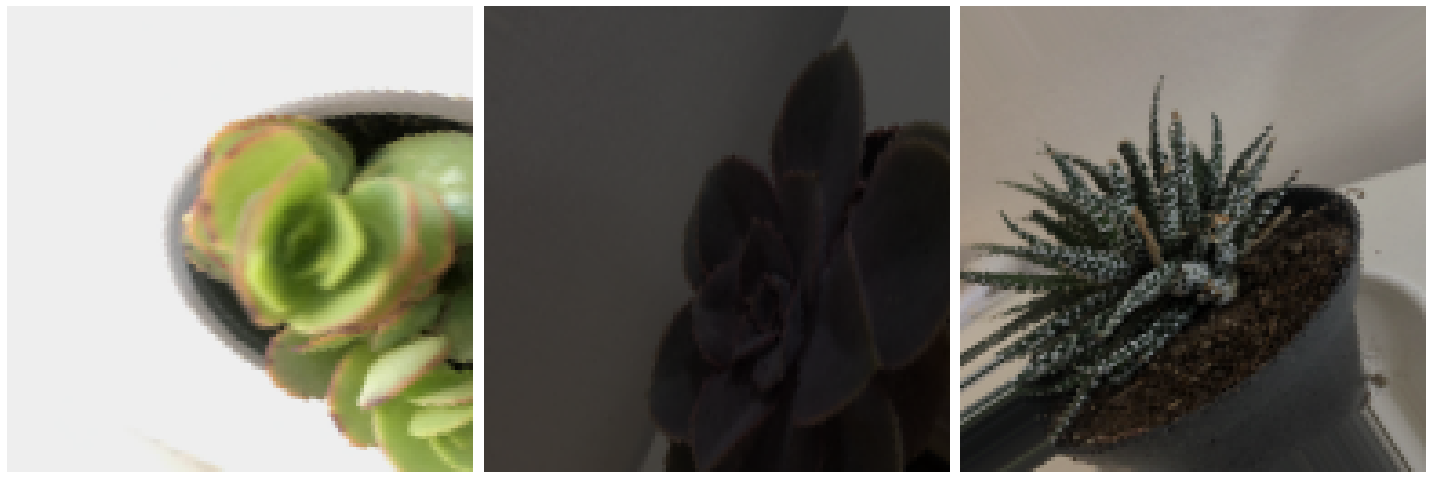

In [ ]:
# This function will plot images in the form of a grid with 1 row and 3 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_generator)
plotImages(sample_training_images[:3])

In [ ]:
# Loading the pre-trained model (MobileNetV2)
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")


87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# Freezing the base model
# base_model.shape=(None, 4, 4, 1280) - too big
base_model.trainable = False
print(base_model.output)
# takes the whole input instead of taking parts at a time
# takes an average of numbers in an input = output of the base_model
# convert features to vectors
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
print(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=15, activation='softmax')(global_average_layer)
print(prediction_layer)

Tensor("mixed10/concat:0", shape=(None, 2, 2, 2048), dtype=float32)
Tensor("global_average_pooling2d_2/Mean:0", shape=(None, 2048), dtype=float32)
Tensor("dense_2/Softmax:0", shape=(None, 15), dtype=float32)


In [ ]:
# Defining the model
# Combining two models
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="sparse_categorical_crossentropy", metrics=["SparseCategoricalAccuracy"])


In [ ]:
train = train_data_generator
valid = valid_data_generator
epochs = 20
history = model.fit(train,  
                    epochs = epochs, 
                    validation_data=valid)

Epoch 1/20
43/43 [==============================] - 156s 4s/step - loss: 3.5569 - sparse_categorical_accuracy: 0.0925 - val_loss: 3.1114 - val_sparse_categorical_accuracy: 0.1343
Epoch 2/20
43/43 [==============================] - 152s 4s/step - loss: 2.6575 - sparse_categorical_accuracy: 0.2316 - val_loss: 2.5424 - val_sparse_categorical_accuracy: 0.2746
Epoch 3/20
43/43 [==============================] - 150s 3s/step - loss: 2.1807 - sparse_categorical_accuracy: 0.3336 - val_loss: 2.2146 - val_sparse_categorical_accuracy: 0.3194
Epoch 4/20
43/43 [==============================] - 148s 3s/step - loss: 1.8033 - sparse_categorical_accuracy: 0.4304 - val_loss: 2.0790 - val_sparse_categorical_accuracy: 0.4090
Epoch 5/20
43/43 [==============================] - 151s 4s/step - loss: 1.5545 - sparse_categorical_accuracy: 0.5208 - val_loss: 1.7021 - val_sparse_categorical_accuracy: 0.4478
Epoch 6/20
43/43 [==============================] - 153s 4s/step - loss: 1.3585 - sparse_categorical_accu

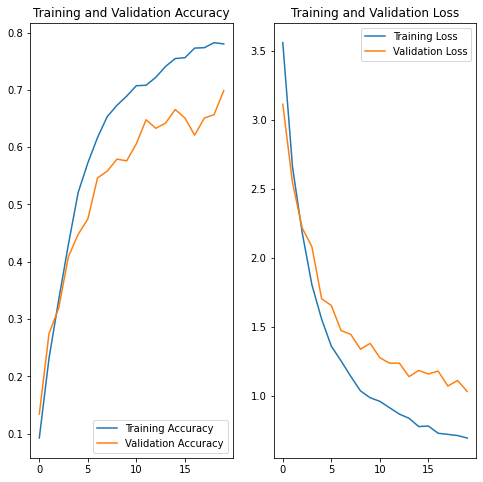

In [ ]:
import plotly.graph_objects as go

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
valid_loss, valid_accuracy = model.evaluate(valid)

11/11 [==============================] - 19s 2s/step - loss: 1.1192 - sparse_categorical_accuracy: 0.6567


In [ ]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.6567164063453674


In [ ]:
test_accu = model.evaluate(test_data_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

6/6 [==============================] - 11s 2s/step - loss: 0.9036 - sparse_categorical_accuracy: 0.7181
The testing accuracy is : 71.80851101875305 %


In [ ]:
#plant_path = 'https://en.wikipedia.org/wiki/Helianthus#/media/File:Sunflower_sky_backdrop.jpg'
flower_path = '/content/Test/Fittonia Verschaffeltii/IMG_1215.JPG'
img = tf.keras.preprocessing.image.load_img(flower_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Dandelion with a 16.26 percent confidence.


In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layersin the base model: {}".format(len(base_model.layers)))

Number of layersin the base model: 311


In [ ]:
fine_tune_at = 100

In [ ]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(train,  
                    epochs = epochs, 
                    validation_data=valid)

Epoch 1/20
43/43 [==============================] - 151s 4s/step - loss: 1.3237 - accuracy: 0.6220 - val_loss: 1.0809 - val_accuracy: 0.6866
Epoch 2/20
43/43 [==============================] - 149s 3s/step - loss: 0.6919 - accuracy: 0.7924 - val_loss: 0.9309 - val_accuracy: 0.7224
Epoch 3/20
43/43 [==============================] - 148s 3s/step - loss: 0.4691 - accuracy: 0.8521 - val_loss: 0.9051 - val_accuracy: 0.7343
Epoch 4/20
43/43 [==============================] - 147s 3s/step - loss: 0.3739 - accuracy: 0.8827 - val_loss: 0.7469 - val_accuracy: 0.7821
Epoch 5/20
43/43 [==============================] - 146s 3s/step - loss: 0.2806 - accuracy: 0.9104 - val_loss: 0.7147 - val_accuracy: 0.7642
Epoch 6/20
43/43 [==============================] - 147s 3s/step - loss: 0.2752 - accuracy: 0.9119 - val_loss: 0.7927 - val_accuracy: 0.7821
Epoch 7/20
43/43 [==============================] - 149s 3s/step - loss: 0.2176 - accuracy: 0.9330 - val_loss: 0.9449 - val_accuracy: 0.7493
Epoch 8/20
43

In [ ]:
valid_loss, valid_accuracy = model.evaluate(valid)

11/11 [==============================] - 19s 2s/step - loss: 0.9638 - accuracy: 0.8090


In [ ]:
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

Validation accuracy after fine tuning: 0.8089552521705627


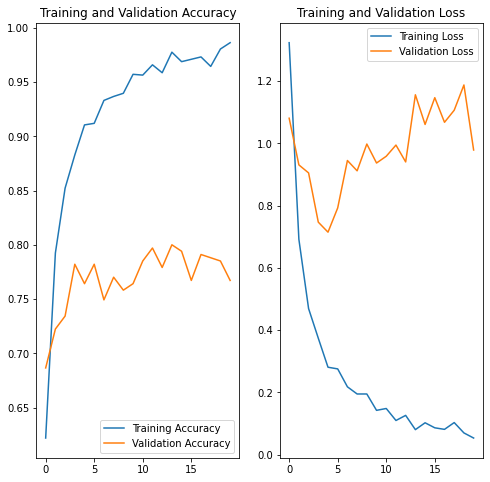

In [ ]:
import plotly.graph_objects as go

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_accu = model.evaluate(test_data_generator)
print('The testing accuracy is :',test_accu[1]*100, '%')

6/6 [==============================] - 11s 2s/step - loss: 0.8003 - accuracy: 0.8564
The testing accuracy is : 85.6382966041565 %


In [ ]:
#plant_path = 'https://en.wikipedia.org/wiki/Helianthus#/media/File:Sunflower_sky_backdrop.jpg'
flower_path = '/content/Test/Jade Plant/IMG_1311.JPG'
img = tf.keras.preprocessing.image.load_img(flower_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)

class_names = test_data_generator.class_indices
print(class_names)
# function to return key for any value
def get_key(val):
    for key, value in class_names.items():
         if val == value:
             return key
 
    return "key doesn't exist"
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_key(np.argmax(predictions)), 100 * np.max(score))
)


{'Daisy': 0, 'Dandelion': 1, 'Fittonia Verschaffeltii': 2, 'Jade Plant': 3, 'Lucky Bamboo': 4, 'Moon Cactus': 5, 'Paddle Plant': 6, 'Parlor Palm': 7, 'Rose': 8, 'Sansevieria Ballyi': 9, 'Sempervivum': 10, 'String Of Banana': 11, 'Sunflower': 12, 'Tulip': 13, 'Zebra Plant': 14}
This image most likely belongs to Jade Plant with a 16.26 percent confidence.


In [ ]:
# Save my model
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 5756
drwxr-xr-x 2 root root    4096 Mar 17 14:39 assets
-rw-r--r-- 1 root root 5882753 Mar 17 18:57 saved_model.pb
drwxr-xr-x 2 root root    4096 Mar 17 18:57 variables


In [ ]:
# Examine your saved model
!saved_model_cli show --dir {export_path} --all

2021-03-17 18:57:31.429043: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 128, 128, 3)
        name: serving_default_input_3:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 15)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow

In [ ]:
# Serve your model with TensorFlow Serving

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  21326      0 --:--:-- --:--:-- --:--:-- 21326
OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubun

In [ ]:
# Install TensorFlow Serving
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.4.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=PlantIL_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


Starting job # 3 in a separate thread.


In [ ]:
!tail server.log

2021-03-17 18:57:54.202801: I tensorflow_serving/model_servers/server_core.cc:464] Adding/updating models.
2021-03-17 18:57:54.202838: I tensorflow_serving/model_servers/server_core.cc:587]  (Re-)adding model: PlantIL_model
2021-03-17 18:57:54.204952: I tensorflow_serving/core/basic_manager.cc:740] Successfully reserved resources to load servable {name: PlantIL_model version: 1}
2021-03-17 18:57:54.205006: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: PlantIL_model version: 1}
2021-03-17 18:57:54.205031: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: PlantIL_model version: 1}
2021-03-17 18:57:54.205087: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:32] Reading SavedModel from: /tmp/1
2021-03-17 18:57:54.325715: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:55] Reading meta graph with tags { serve }
2021-03-17 18:57:54.325790: I external/org_tensorflow/tensorflow/cc/saved_model/

## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

['Daisy', 'Dandelion', 'Fittonia Verschaffeltii', 'Jade Plant', 'Lucky Bamboo', 'Moon Cactus', 'Paddle Plant', 'Parlor Palm', 'Rose', 'Sansevieria Ballyi', 'Sempervivum', 'String Of Banana', 'Sunflower', 'Tulip', 'Zebra Plant']


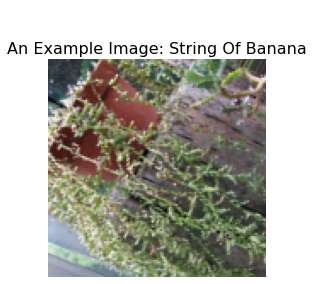

In [ ]:
test = test_data_generator
test_images, test_labels  = next(test)
test_labels = [int(i) for i in list(test_labels)]
class_names = list(test_data_generator.class_indices.keys())
print(class_names)

def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx])
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [ ]:
import json
test = test_data_generator
test_images, test_labels  = next(test)
test_labels = [int(i) for i in list(test_labels)]
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:10].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/PlantIL_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
print(predictions[0])
print(np.argmax(predictions[0]))

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

In [ ]:
model.save('/content/InceptionV3-15class.h5')
model.save('/content/gdrive/MyDrive/InceptionV3-15class.h5')


